In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colormaps
from b3d.io import FeatureTrackData, get_shared
from b3d.utils import keysplit, downsize_images
from b3d.camera import Intrinsics
from b3d.pose import Pose
import rerun as rr

key = jax.random.PRNGKey(0)

In [3]:
from b3d.camera import screen_from_world, world_from_screen
from b3d.chisight.sfm.particle_inference import gaussian_from_keypoint

from b3d.plotting import plot_segs
from b3d.plotting import gaussian_mesh_from_xs_and_covs


from sklearn.utils import Bunch


In [4]:
def rgb_for_uv_from_img(uvs, img_rgb):
    ji = jnp.floor(uvs).astype(jnp.int32)
    return img_rgb[ji[..., 1], ji[..., 0], :]

def normalize(x):
    return (x - x.min())/(x.max() - x.min())

In [5]:
# Rotation Matrix for a camera that
# points along the y-axis.
CAM_ALONG_Y = jnp.array([
    [1,0,0],
    [0,0,1],
    [0,-1,0]
])

# Fixed universal camera
_cam0 = Pose.from_pos_matrix(jnp.array([0., -4., 0.]), CAM_ALONG_Y)

In [6]:


def create_box_mesh(dims=np.array([1.,1.,1.])):

    # Define the 8 vertices of the box
    w, h, d = dims/2.
    vertex_positions = np.array([
        [-w, -h, -d],
        [ w, -h, -d],
        [ w,  h, -d],
        [-w,  h, -d],
        [-w, -h,  d],
        [ w, -h,  d],
        [ w,  h,  d],
        [-w,  h,  d],
    ])

    # Define the 12 triangles (two per face)
    triangle_indices = np.array([
        [0, 1, 2], [0, 2, 3],  # Front face
        [4, 5, 6], [4, 6, 7],  # Back face
        [0, 1, 5], [0, 5, 4],  # Bottom face
        [2, 3, 7], [2, 7, 6],  # Top face
        [0, 3, 7], [0, 7, 4],  # Left face
        [1, 2, 6], [1, 6, 5],  # Right face
    ])
    vertex_normals = vertex_positions

    return vertex_positions, triangle_indices, vertex_normals


def create_pose_bunch(p, c=jnp.array([.7,.7,.7]), s=1.0, dims=np.array([.2, .2, 1.])):
    vs, fs, ns = create_box_mesh(dims=s*dims)

    if c is None: c = jnp.array([.7,.7,.7])
    cs = c[None, :] * jnp.ones((vs.shape[0], 1))

    return Bunch(
        vertex_positions = p(vs),
        triangle_indices = fs,
        vertex_normals = p.rot.apply(ns),
        vertex_colors = cs,
    )

def log_pose(s, p, c=jnp.array([.7,.7,.7]), scale=1., dims=np.array([.2,.2,1.])):
    rr.log(s, rr.Mesh3D(
            **create_pose_bunch(p, c=c, s=scale, dims=dims),
            # mesh_material=rr.components.Material(albedo_factor=[255, 255, 255]),
    ))




In [7]:
from b3d.plotting import gaussian_mesh_from_ps_and_diags
from b3d.chisight.gps_utils import (
    gaussian_pdf_product,
    gaussian_pdf_product_multiple, 
    cov_from_dq_composition
)
from b3d.pose import uniform_pose_in_ball
vmap_uniform_pose = jax.jit(jax.vmap(uniform_pose_in_ball.sample, (0,None,None,None)))


# Load Feature Track Data

In [8]:
path = get_shared()/"dynamic_SfM/feature_track_data/"

print(f"{path.name}:")
files = os.listdir(path)
for i, f in enumerate(files):
    print(f" - ({i}) \033[1m{f}\033[0m")

feature_track_data:
 - (0) grab_box_2_pixel4a.FeatureTrackData.npz
 - (1) plantRoomLookingThrough_30fps_lit_bg_800p.input.npz
 - (2) plantRoomLookingThrough_30fps_lit_bg_800p.input.npz_.gstmp
 - (3) slidingBooks_60fps_lit_bg_800p.input.npz_.gstmp
 - (4) slidingPiledBooks_60fps_lit_bg_800p.input.npz
 - (5) grab_box_1_pixel4a.FeatureTrackData.npz
 - (6) grab_box_2_pixel4a.FeatureTrackData.npz_.gstmp
 - (7) slidingBooks_60fps_lit_bg_800p.input.npz
 - (8) slidingPiledBooks_60fps_lit_bg_800p.input.npz_.gstmp



FeatureTrackData:
    Num Frames: 271
    Num Keypoints: 8823
    Image shape (width x height): 800 x 800
    FPS: None

Intrinsics(width=Array(800, dtype=int32), height=Array(800, dtype=int32), fx=Array(466.66666, dtype=float32), fy=Array(466.66666, dtype=float32), cx=Array(400., dtype=float32), cy=Array(400., dtype=float32), near=Array(0.01, dtype=float32), far=Array(10., dtype=float32))


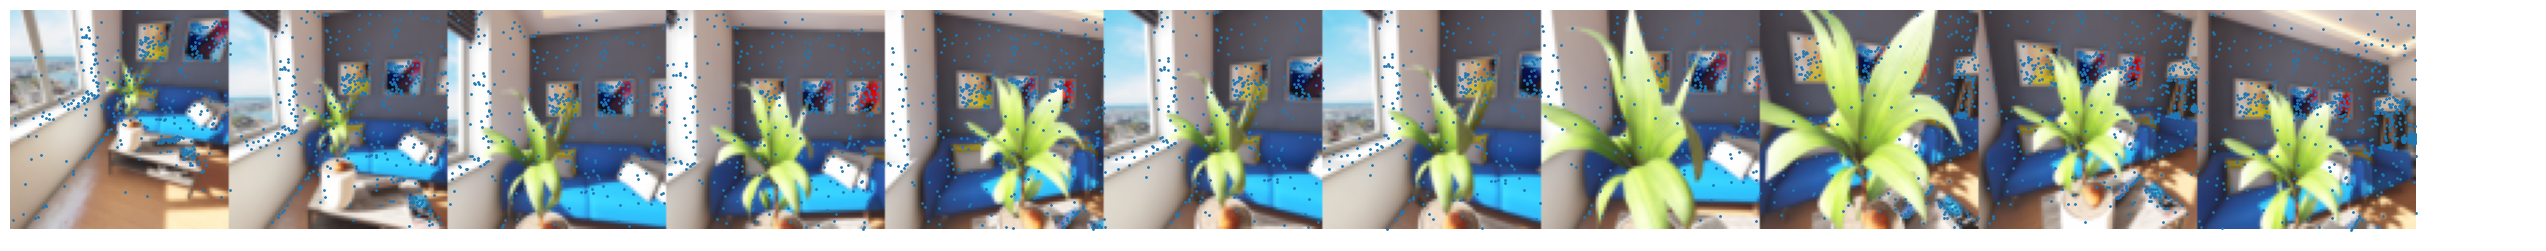

In [17]:
fname = path/files[1]
data = FeatureTrackData.load(fname)

_T = data.shape[0]
_N = data.shape[1]
_uvs = data.uv
_vis = data.vis
_rgb = data.rgb_uint
_cols = rgb_for_uv_from_img(_uvs[0], _rgb[0])
_intr = Intrinsics.from_array(data.camera_intrinsics)

print(data)
print(_intr)

_downsize = 10
_rgb_small = downsize_images(_rgb, _downsize)

data[::len(data)//10].quick_plot(downsize=10, )

## Pick a pair of frames

In [18]:
data.num_frames

271

199
(150, 2)
(150, 2)


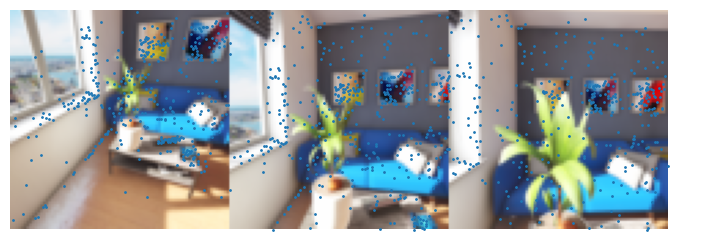

In [21]:
t0 = 0
t1 = 40
t2 = 80

# Let's pick N keypoints 
# that are visible in both frames.
vis_ = _vis[t0]*_vis[t1]*_vis[t2]

print(vis_.sum())

sub = np.random.choice(np.where(vis_ == True)[0],150, replace=False)
vis = np.zeros(vis_.shape)
vis[sub] = 1.
vis = jnp.array(vis == 1.)

# Keypoints for both frames
uvs0 = _uvs[t0,vis]
uvs1 = _uvs[t1,vis]
uvs2 = _uvs[t2,vis]

cols = _cols[vis]/255
print(uvs0.shape)
print(uvs1.shape)


# ==========================
data[jnp.array([t0,t1,t2])].quick_plot(downsize=10, figsize=(3,3))

In [22]:
xs_true = data.latent_keypoint_positions[t0][vis]
xs_true = data.camera_poses[t0].inv()(xs_true)
p_true =  data.camera_poses[t0].inv()@data.camera_poses[t1]

In [23]:
intr = _intr

In [24]:
del data;

# Experiments

In [25]:
from b3d.chisight.gps_utils import ellipsoid_embedding
from b3d.camera import camera_from_screen_and_depth

from b3d.camera import (
    screen_from_world, 
    screen_from_camera,
    world_from_screen, 
)


# Math

## Map Posterior

**Plain Version:**
$$
\begin{darray}{rcl}
    P(x \mid y_{:t}, c_{:t}) 
        &\propto& P(y_{:t} \mid x, c_{:t}) \ P(x)
        \\ \\ &=& \prod_i P(y_{:t,i} \mid x_i, c_{:t}) \ P(x_i)
\end{darray}
$$

**Recursive Version:**
$$
\begin{darray}{rcl}
    P(x \mid y_{:t}, c_{:t}) 
        &\propto& P(y_{t} \mid x, c_{t}) \ P(x \mid y_{:t-1}, c_{:t-1})
        \\ \\ &=&  \prod_i  P( y_{t,i} \mid x_i, c_{t}) \ P(x_i \mid y_{:t-1,i}, c_{:t-1})
\end{darray}
$$


## Camera Posterior

$$
\begin{darray}{rcl}
  P(c \mid y) 
    &\propto& P(c) \ P(y \mid c)
    \\ &=& 
      P(c) \int P(y \mid c, x) \ P(x) \ dx 
    \\ &=& 
      P(c) \int P(y \mid c, x) \ \tfrac{P(x)}{Q(x)} \ Q(x) \ dx
    \\
    \\
    \\ &\approx& 
      P(c) \ \tfrac{1}{S} \sum_j P(y \mid c, x_j) \ \tfrac{P(x_j)}{Q(x_j)}
    \\ &=& 
      P(c) \ \tfrac{1}{S}  \sum_j
      \Big[ \prod_{t}P( y_{t} \mid x_{j}, c_t) \Big] 
      \tfrac{P(x_j)}{Q(x_j)}
  \\ &=& 
      P(c) \ \tfrac{1}{S} \sum_j
      \Big[ \prod_{t,i}P( y_{ti} \mid x_{i,j}, c_t) \Big] 
      \Big[ \prod_i \tfrac{ P(x_{i,j})}{ Q(x_{i,j})} \Big]

  \\ &=& 
      P(c) \ \tfrac{1}{S} \sum_j
      \Big[ \prod_{i} w_{ij} \prod_{t} \ell_{ijt}   \Big]
\end{darray}
$$

Here the $x_j = (x_{1j}, \ldots, x_{nj}) \sim Q = \prod_i Q_i$ are samples from the particle proposal. We can assume $Q(x) = Q( x \mid y, c )$ and use the posterior over particle positions $P(x \mid y, c)$ or some approximation.

**Approximate log score:**
$$
\log P(c \mid y) \stackrel{\propto}{\approx} \log P(c) - \log S + \log \sum_j \exp \Big[ \sum_{t,i} \log \ell_{t, ij} + \sum_i \log w_{ij} \Big]
$$

### Sampling efficiency

**Note:** Sampling efficiency is a problem &mdash; the space of particles is of dimension $3n$. Unfortunately we have
$$
  \int \prod_i P(y_i \mid c, x_i) \ P(x_i) \ dx  \stackrel{!}{\neq}   \ \prod_i \int P(y_i \mid c, x_i) \ P(x_i) \  dx_i.
$$

 - Q: How do we get around that?
 - We actually want to score a particle posterior
 - We should approximate $P(x_i \mid y_{:t,i}, c_{:t})$ using importance sampling with a simple $Q_i$.

In [35]:
import jax
import jax.numpy as jnp
import genjax
from genjax import Pytree
from b3d.pose import Pose, uniform_pose_in_ball
from b3d.camera import screen_from_world
from genjax import ChoiceMapBuilder as C
from genjax._src.core.generative.choice_map import EmptyChm



@genjax.gen
def camera_motion_model(carry, _):
    p, rx, rq = carry
    p = uniform_pose_in_ball(p, rx, rq) @ "x"
    carry = (p, rx, rq)
    return carry, p


@genjax.gen
def observation_model(xs, cam, intr, sig):
    ys_ = screen_from_world(xs, cam, intr)
    ys  = genjax.normal.vmap(in_axes=(0,None))(ys_,jnp.array([sig,sig])) @ "sensor_coordinates"
    return ys


@genjax.gen
def model(T, N, c0=Pose.id()):
    T = T.const
    N = N.const

    obs_sig = jnp.array(10.0)
    intr = _intr
    cam_rx = jnp.array(0.1)
    cam_rq = jnp.array(0.1)

    xs = genjax.repeat(n=N)(genjax.uniform)(10.*jnp.ones(3), 10.*jnp.ones(3)) @ "particle_positions"
    _, cs = genjax.scan(n=T)(camera_motion_model)((c0, cam_rx, cam_rq), None) @ "camera_poses"
    ys = observation_model.vmap(in_axes=(None, 0, None, None))(xs, cs, intr, obs_sig) @ "observations"

    return {
        "xs": xs, 
        "cs": cs,
        "ys": ys
    }


T = 2
N = uvs0.shape[0]

model_args = (
    Pytree.const(T),
    Pytree.const(N)
)
key = jax.random.PRNGKey(0)
tr, w = model.importance(key, EmptyChm(), model_args)

In [37]:
ch = EmptyChm()
ch = ch.at[
    "observations", 
    jnp.arange(T),
    "sensor_coordinates", 
    jnp.tile(jnp.arange(N), (T,1))
].set(jnp.stack([uvs0,uvs1], axis=0))
ch = ch.at[
    "observations", 
    jnp.arange(T),
    "sensor_coordinates", 
    jnp.tile(jnp.arange(N), (T,1))
].set(jnp.stack([uvs0,uvs1], axis=0))
tr, w = model.importance(key, ch, model_args)

In [36]:
tr.get_choices()

XorChm(
  c1=XorChm(
    c1=StaticChm(
      addr='particle_positions',
      c=IdxChm(addr=<jax.Array int32(150,) [≥0, ≤149] zero:1 nonzero:149>, c=ValueChm(v=<jax.Array float32(150, 3) ≈1e+01 ±0.0 [≥1e+01, ≤1e+01] nonzero:450>)),
    ),
    c2=StaticChm(
      addr='camera_poses',
      c=IdxChm(addr=<jax.Array([0, 1], dtype=int32)>, c=StaticChm(addr='x', c=ValueChm(v=<b3d.pose.core.Pose object at 0x7fb7d7f606d0>))),
    ),
  ),
  c2=StaticChm(
    addr='observations',
    c=IdxChm(
      addr=<jax.Array([0, 1], dtype=int32)>,
      c=StaticChm(addr='sensor_coordinates', c=IdxChm(addr=<jax.Array int32(2, 150) [≥0, ≤149] zero:2 nonzero:298>, c=ValueChm(v=<jax.Array float32(2, 150, 2) ≈9.5e+02 ±1.4e+02 [≥7.8e+02, ≤1.2e+03] nonzero:600>))),
    ),
  ),
)

In [32]:
ch = C[
    "observations", 
    jnp.arange(T),
    "sensor_coordinates", 
    jnp.tile(jnp.arange(N), (T,1))
].set(jnp.stack([uvs0,uvs1], axis=0))
tr, w = model.importance(key, ch, model_args)

In [34]:
from genjax.inference import Target


target = Target(model, model_args, ):

SyntaxError: invalid syntax (3045529295.py, line 3)

In [16]:
from functools import partial
from jax.scipy.special import logsumexp


def make_camera_scorer(observation_model_logpdf, particle_proposal):
    """
    Args:

        observation_model_logpdf: Function that takes (y, x, cam, intr) and 
            returns logP(y| cam, x)

        particle_proposal: Sampler that takes (key, ys[:T,i], cams[:T], intr) and 
            returns a tuple (x[i], logQ(x[i])), containing a scored particle 
            proposal.

    We assume both the observation model and proposal are independent with respect to each particle.
    We assume p(c) and p(x) are constant.
    """
    obs_model_mapped_over_i  = jax.vmap(observation_model_logpdf, (0, 0, None, None, None))
    obs_model_mapped_over_ti = jax.vmap(obs_model_mapped_over_i, (0, None, 0, None, None))

    proposal_mapped_over_i   = jax.vmap(particle_proposal, (0, 1, None, None))
    proposal_mapped_over_si  = jax.vmap(proposal_mapped_over_i, (0,None,None,None))

    def camera_score(key, ys, cams, intr, sig, S):
        
        T = ys.shape[0]
        N = ys.shape[1]

        # Branch and get random keys 
        # for the particle proposals
        key = jax.random.split(key)[1]
        keys = jax.random.split(key, (S,N))

        # Sample from particle proposal
        # Shapes: (S,N,3) and (S,N)
        xs, log_qxs = proposal_mapped_over_si(keys, ys, cams, intr)
        
        # Compute the importance weights
        # Shape: (S,N)
        # Assuming uniform $P(x)$ then $w_{ij} = P(x)/Q(x) \propto 1/Q(x)$
        ws = - log_qxs

        # Compute data likelihoods 
        # Shape: (S, T, N)
        log_pys = jax.vmap(obs_model_mapped_over_ti, (None,0,None,None, None))(ys, xs, cams, intr, sig)
        
        # NOTE: Falsly assuming $p(y | c) = \prod_i p(y_i | c)$ 
        #   would give the score `logsumexp(log_pys.sum(1), axis=0).sum() - N*jnp.log(S)`

        score = logsumexp(log_pys.sum((1,2)) + ws.sum(1)) - jnp.log(S)

        return score


    @partial(jax.jit, static_argnames=("S",))
    def particle_inference(key, ys, cams, intr, sig, S):

        T = ys.shape[0]
        N = ys.shape[1]

        # Branch and get random keys 
        # for the particle proposals
        key = jax.random.split(key)[1]
        keys = jax.random.split(key, (S,N))

        # Shapes should be (S,N,3) and (S,N)
        xs, log_qxs = proposal_mapped_over_si(keys, ys, cams, intr)

        # Shape should be (S, T, N)
        log_pys = jax.vmap(obs_model_mapped_over_ti, (None,0,None,None,None))(ys, xs, cams, intr, sig)

        scores = log_pys.sum(1)
        ii = jnp.argmax(scores, axis=0)
        xs_winner = xs[ii,jnp.arange(N)]

        return xs_winner 


    return camera_score, particle_inference




In [241]:

from jax.scipy.stats.norm import logpdf as normal_logpdf


def particle_proposal_0(key, ys_Tx2, cams_T, intr):
    t = 0
    y = ys_Tx2[t]
    cam = cams_T[t]

    z = jax.random.uniform(key, minval=intr.near, maxval = intr.far)
    x = cam(camera_from_screen_and_depth(y, z, intr))

    return x, 0.0

def particle_proposal_1(key, ys_Tx2, cams_T, intr):
    t = 1
    y = ys_Tx2[t]
    cam = cams_T[t]

    z = jax.random.uniform(key, minval=intr.near, maxval = intr.far)
    x = cam(camera_from_screen_and_depth(y, z, intr))

    return x, 0.0

def observation_model_logpdf(y, x, cam, intr, sig=10.):
    y_ = screen_from_world(x, cam, intr, culling=True) 
    logp = normal_logpdf(y - y_, 0., sig).sum()
    # logp = - jnp.linalg.norm(y - y_)
    return jnp.clip(logp, -1e6, jnp.inf)
                    
    


camera_score, particle_inference = make_camera_scorer(observation_model_logpdf, particle_proposal_0)

intr = Intrinsics(*_intr[:-2], 1e-1,10.0)
ys = jnp.stack([uvs0, uvs1], axis=0)

vmap_camera_score = partial(jax.jit, static_argnames=("S",))(jax.vmap(
    lambda key, ys, cam, intr, sig, S: 
        camera_score(key, ys, Pose.stack_poses([Pose.id(), cam]), intr, sig, S), (0, None, 0, None, None, None)
))


In [242]:
intr = Intrinsics(*_intr[:-2], 1e-1,10.0)
ys = jnp.stack([uvs0, uvs1], axis=0)
cams = Pose.stack_poses([Pose.id(), p_true])


    ys: (2, 150, 2)
    xs: (1000, 150, 3) (1000, 150, 3)
    cams: (2,)
      
    log p(y | ...): (1000, 2, 150)
    finite: 100.0 %  100.0 %

    score: -2168.19775390625
    score: -2167.3740234375




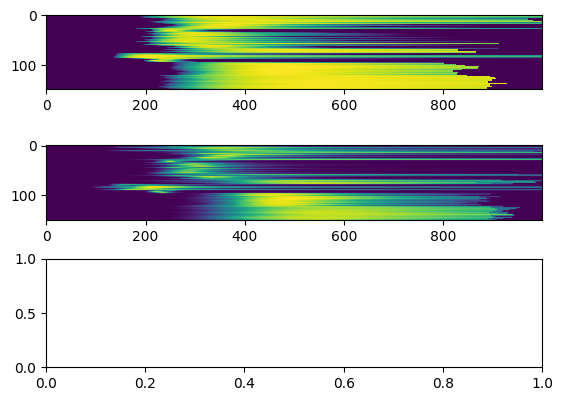

In [290]:
obs_model_mapped_over_i  = jax.vmap(observation_model_logpdf, (0, 0, None,None, None))
obs_model_mapped_over_ti = jax.vmap(obs_model_mapped_over_i, (0, None, 0, None, None))

proposal_0_mapped_over_i   = jax.vmap(particle_proposal_0, (0, 1, None, None))
proposal_0_mapped_over_si  = jax.vmap(proposal_0_mapped_over_i, (0,None,None,None))

proposal_1_mapped_over_i   = jax.vmap(particle_proposal_1, (0, 1, None, None))
proposal_1_mapped_over_si  = jax.vmap(proposal_1_mapped_over_i, (0,None,None,None))

proposal_mapped_over_i   = jax.vmap(particle_proposal_0, (0, 1, None, None))
proposal_mapped_over_si  = jax.vmap(proposal_mapped_over_i, (0,None,None,None))


S = 1_000
T = ys.shape[0]
N = ys.shape[1]
sig = jnp.array(10.)

# Branch and get random keys 
# for the particle proposals
key = jax.random.split(key)[1]
keys = jax.random.split(key, (S,N))

# Shapes should be (S, N, 3) and (S, N)
xs_, log_qxs = proposal_mapped_over_si(keys, ys, cams, intr)

# Sort xs for better visualization
ii = jnp.argsort(xs_[:,:,2], axis=0)
xs = xs_[ii,jnp.arange(N)]

           
# Shape should be (S, T, N)
log_pys = jax.vmap(obs_model_mapped_over_ti, (None,0,None,None,None))(ys, xs, cams, intr, sig)
log_pys_ = jax.vmap(obs_model_mapped_over_ti, (None,0,None,None,None))(ys, xs_, cams, intr, sig)


score = logsumexp(log_pys.sum(1), axis=0).sum() - N*jnp.log(S)

fin = jnp.isfinite(log_pys.sum(1)).reshape(-1)
fin_ = jnp.isfinite(log_pys_.sum(1)).reshape(-1)

print(f"""
    ys: {ys.shape}
    xs: {xs.shape} {xs_.shape}
    cams: {cams.shape}
      
    log p(y | ...): {log_pys.shape}
    finite: {fin.sum()/(S*N)*100} %  {fin_.sum()/(S*N)*100} %

    score: {score}
    score: {camera_score(key, ys, cams, intr, sig, S)}

""")


ws = log_pys.sum(1).reshape(-1)[fin]
ws = jnp.clip(ws, jnp.quantile(ws, 0.8), jnp.inf)
ws -= logsumexp(ws, axis=0, keepdims=True) 


xs_inferred = particle_inference(key, ys, cams, intr, sig, S)

# =============================
fig, axs = plt.subplots(3,1)
axs[0].imshow(log_pys.sum(1).T, vmin=jnp.quantile(log_pys.sum(1), 0.4))
axs[1].imshow(jnp.exp(log_pys.sum(1)).T)


rr.init("Debugging")
rr.connect("127.0.0.1:8812")
rr.set_time_sequence("frame_idx", 0)



rr.log("Proposals", rr.Points3D(
    _cam0(xs.reshape(-1,3)[fin]), 
    # colors=[0.9,0.9,0.9],
    colors=colormaps["viridis"](normalize(ws)),
    radii=0.02))

rr.log("Ground_Truth", rr.Points3D(
    _cam0(xs_true), 
    colors=[1.,0.,0.],
    radii=0.05))


rr.log("Proposals2", rr.Points3D(
    proposal_1_mapped_over_si(keys, ys, _cam0@cams, intr)[0].reshape(-1,3), 
    colors=[0.9,0.9,0.9],
    radii=0.02))

rr.log("props slice", rr.Points3D(
    _cam0(xs[0]), 
    colors=[0.9,0.9,0.9],
    radii=0.1))


rr.log("Inferred", rr.Points3D(
    _cam0(xs_inferred), 
    colors=cols,
    radii=0.1))


In [245]:
intr = Intrinsics(*_intr[:-2], 1e-2,10.0)
ys = jnp.stack([uvs0, uvs1], axis=0)
cams = Pose.stack_poses([Pose.id(), p_true])

In [201]:
p = p_true

True -2415.484
Iter -3354.7654
Iter -3288.0547
Iter -3215.419
Iter -3134.6152
Iter -3044.722
Iter -2935.0657
Iter -2800.2363
Iter -2629.351
Iter -2387.6646
Iter -2178.2974


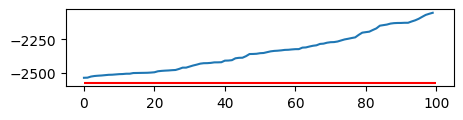

In [289]:
# p = Pose.id()

steps = 10
rx_schedule = jnp.linspace(1.,.05, steps)
rq_schedule = jnp.linspace(0.3,.05, steps)
sig_schedule = jnp.linspace(100.,5., steps)
test_samples = 5_000
S = 20

print("True", camera_score(key, ys, Pose.stack_poses([Pose.id(), p_true]), intr, sig_schedule[-1], S))

for rx, rq, sig in zip(rx_schedule, rq_schedule, sig_schedule):

    key = jax.random.split(key)[1]
    keys = jax.random.split(key, test_samples)
    ps = vmap_uniform_pose(keys, p, rx, rq)[:-1].concat(p[None])

    key = jax.random.split(key)[1]
    keys = jax.random.split(key, test_samples)
    
    ws = vmap_camera_score(keys, ys, ps, intr, sig, S)
    w0 = camera_score(key, ys, Pose.stack_poses([Pose.id(), p_true]), intr, sig, S)
    perm = jnp.argsort(ws)

    p = ps[perm[-1]]
    cams = cams._at_set(1, p)
    
    print("Iter", camera_score(key, ys, Pose.stack_poses([Pose.id(), p]), intr, sig, S))

    

# =================
plt.figure(figsize=(5,1))
plt.hlines(w0, 0, 100, color="r")
plt.plot(ws[perm][-100:])